# Mileage
Average and total mileage. Tabular data is computed to be later visualized on a map.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.rcParams['figure.figsize'] = (10, 6)
pd.options.display.max_columns = 50
pd.options.display.max_rows = 20

inspections_data_path = '../../../inspections/data/'
station_list_path = '../../../station_list/data/station_list.csv'

## Load data

In [12]:
from genericpath import exists


inspections_cols = [
    'StationId',
    'Date',
    'VehicleType',
    'Km',
]
dtypes = {
    'StationId': 'str',
    'VehicleType': 'category',
    'Km': np.float64
}


def load_year(year):
    df_all = None

    for name in [f'{year}-{month:02}' for month in range(1, 13)]:
        # print(f'Load: {name}')
        if exists(f'{inspections_data_path}nosync/data_csv/{name}.csv'):
            df = pd.read_csv(f'{inspections_data_path}nosync/data_csv/{name}.csv',
                             usecols=inspections_cols,
                             dtype=dtypes,
                             index_col=False)
            df['Date'] = pd.to_datetime(df['Date'])

        if df_all is None:
            df_all = df
        else:
            df_all = pd.concat([df_all, df])

    return df_all


years = [
    '2018',
    '2019',
    '2020',
    '2021',
    '2022'
]
dfs_p = {} # Personal vehicles
dfs_np = {} # Cargo vehicles


for year in years:
    print(year)
    
    df = load_year(year)
    
    df_p = df[(df['VehicleType'] == 'OSOBNÍ AUTOMOBIL') | (df['VehicleType'] == 'MOTOCYKL')]
    dfs_p[year] = df_p

    df_np = df[(df['VehicleType'] == 'NÁKLADNÍ AUTOMOBIL')]
    dfs_np[year] = df_np


2018
2019
2020
2021
2022


### Prepare geographical breakdown of stations

In [13]:
stations = pd.read_csv(station_list_path,
                       usecols=['StationId', 'NUTS3'],
                       dtype={
                           'StationId': 'str',
                           'NUTS3': 'category',
                       })
stations = stations.set_index('StationId')


In [16]:
# Add NUTS3 to each inspection observation

def add_geo(df, stations):
    return df.join(stations, on='StationId')

for dfs in [dfs_p, dfs_np]:
    for year, df in dfs.items():
        dfs[year] = add_geo(df, stations)


## Total mileage per area (current year)
To be visualized on a map.

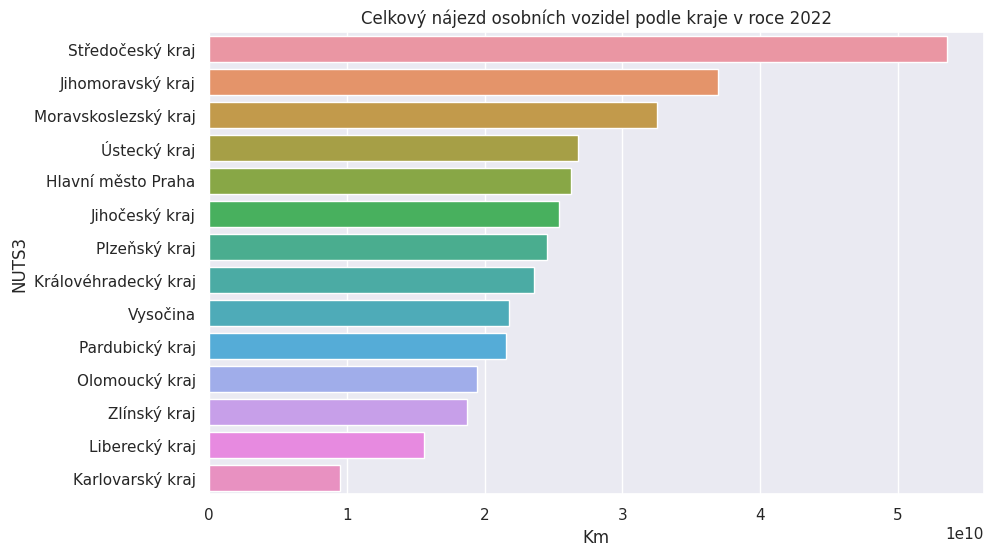

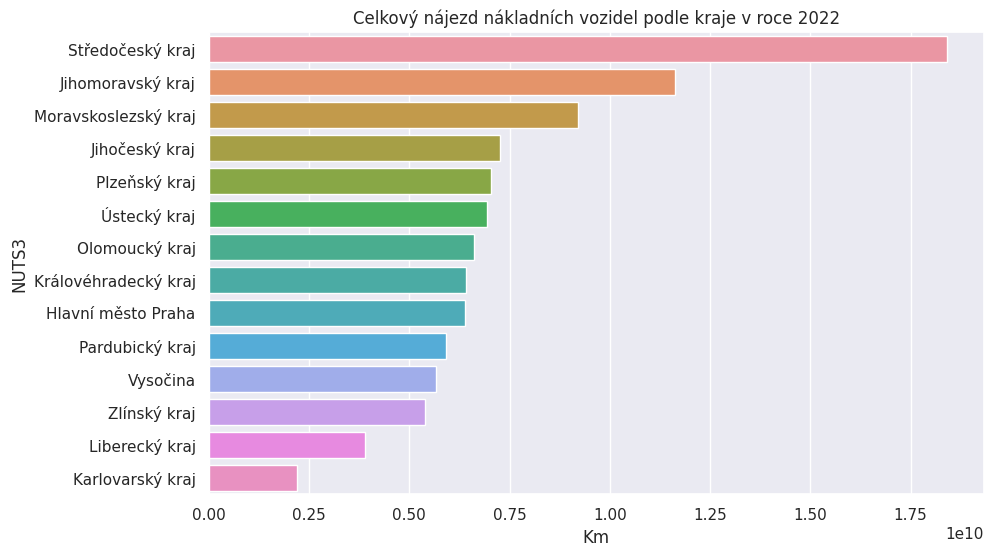

In [50]:
for type, df in [('osobních', dfs_p['2022']), ('nákladních', dfs_np['2022'])]:
    totals = df.groupby('NUTS3')['Km'].sum()
    totals = totals.sort_values(ascending=False)
    plt.title(f'Celkový nájezd {type} vozidel podle kraje v roce 2022')
    sns.barplot(x=totals, y=totals.index, orient='h', order=totals.index)
    plt.show()
    

## Average

#### Change over time

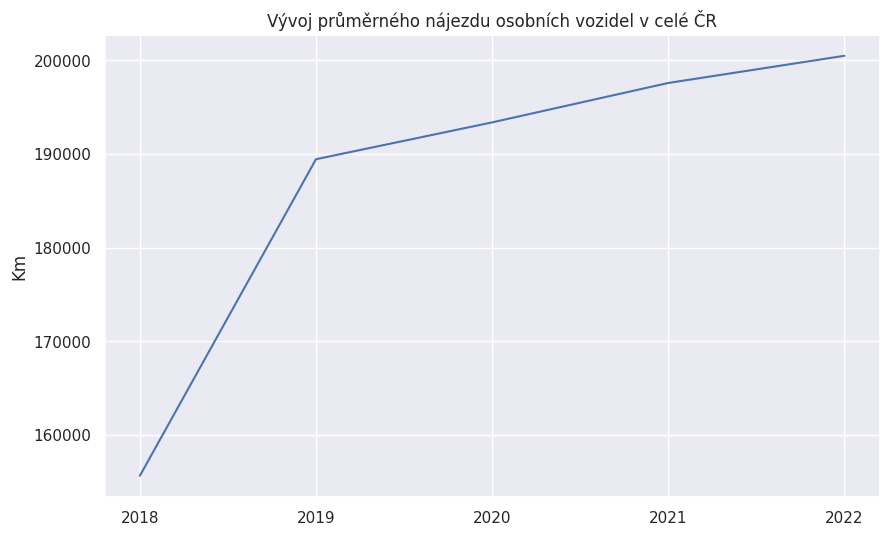

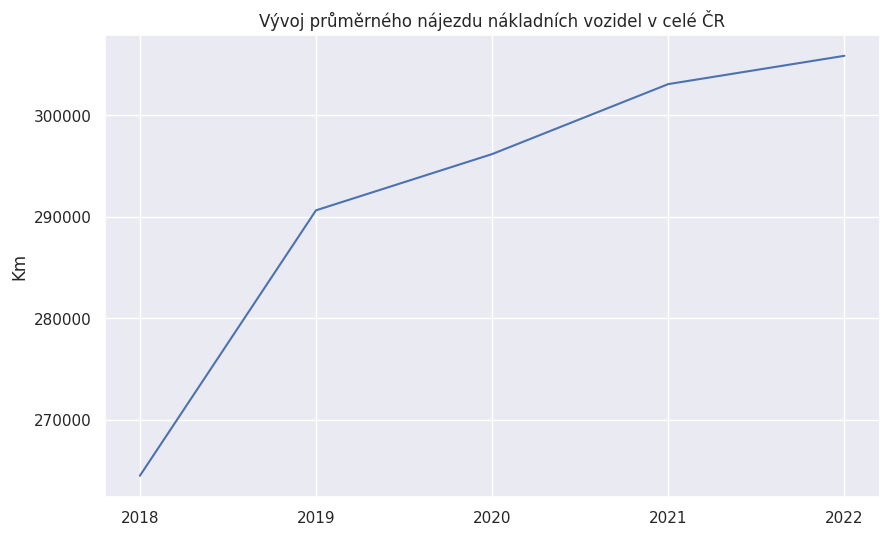

In [63]:
for type, dfs in [('osobních', dfs_p), ('nákladních', dfs_np)]:
    averages_list = []
    
    for year, df in dfs.items():
        average = df['Km'].mean()
        averages_list.append(average)

    averages = pd.Series(averages_list, index=list(dfs.keys()), name='Km')
    
    plt.title(f'Vývoj průměrného nájezdu {type} vozidel v celé ČR')
    sns.lineplot(averages)
    plt.show()

The 2018 dataset looks like it only includes younger vehicles with lower mileage, which corresponds to the average vehicle age analysis.

#### Last year

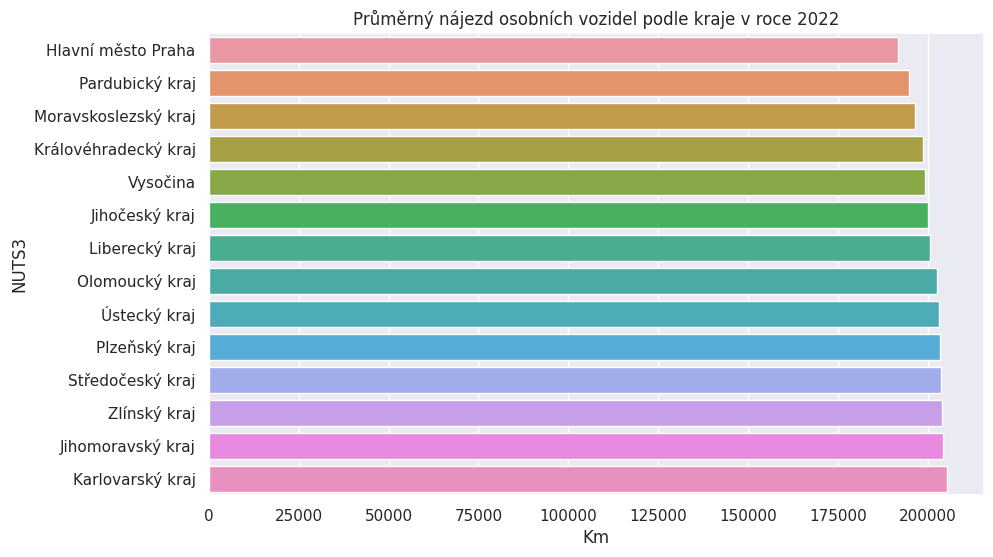

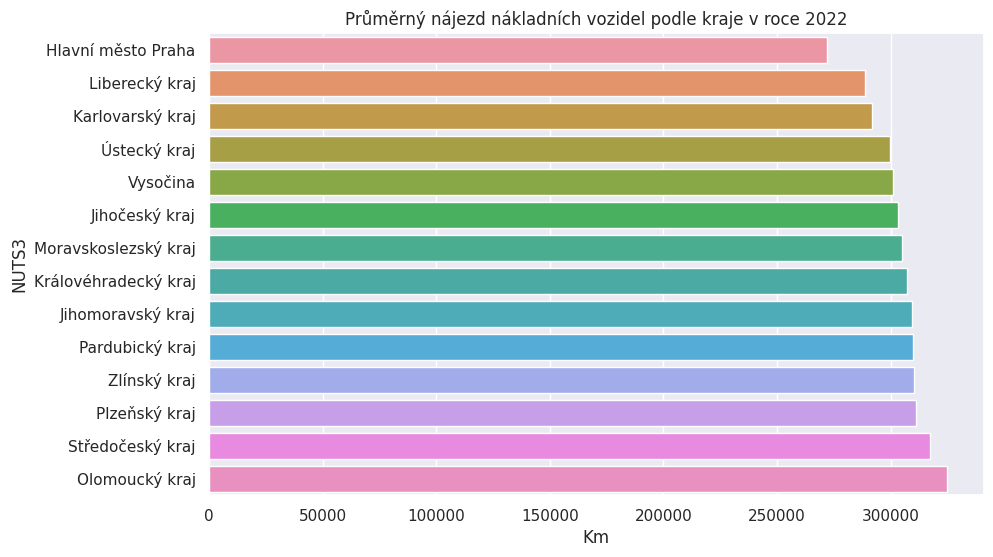

In [64]:
for type, df in [('osobních', dfs_p['2022']), ('nákladních', dfs_np['2022'])]:
    averages = df.groupby('NUTS3')['Km'].mean()
    averages = averages.sort_values(ascending=True)
    plt.title(f'Průměrný nájezd {type} vozidel podle kraje v roce 2022')
    sns.barplot(x=averages, y=averages.index, orient='h', order=averages.index)
    plt.show()

#### Last year's histogram

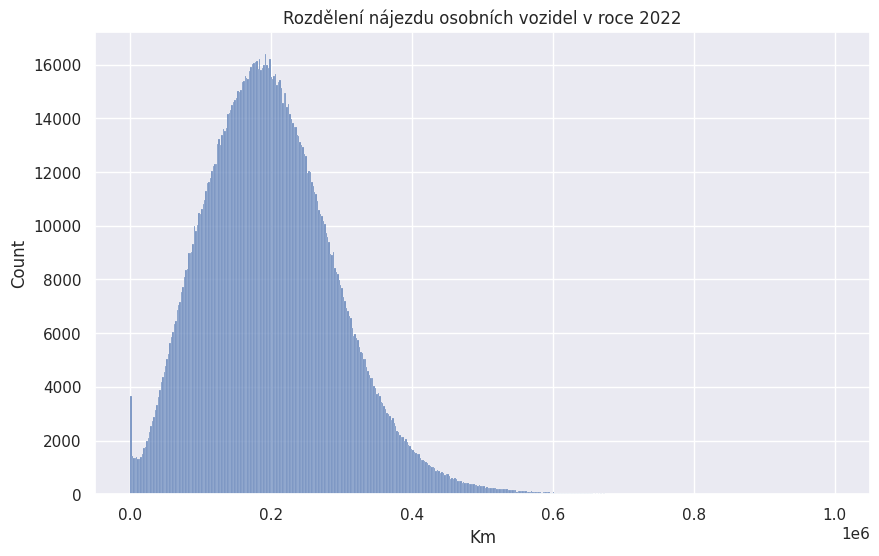

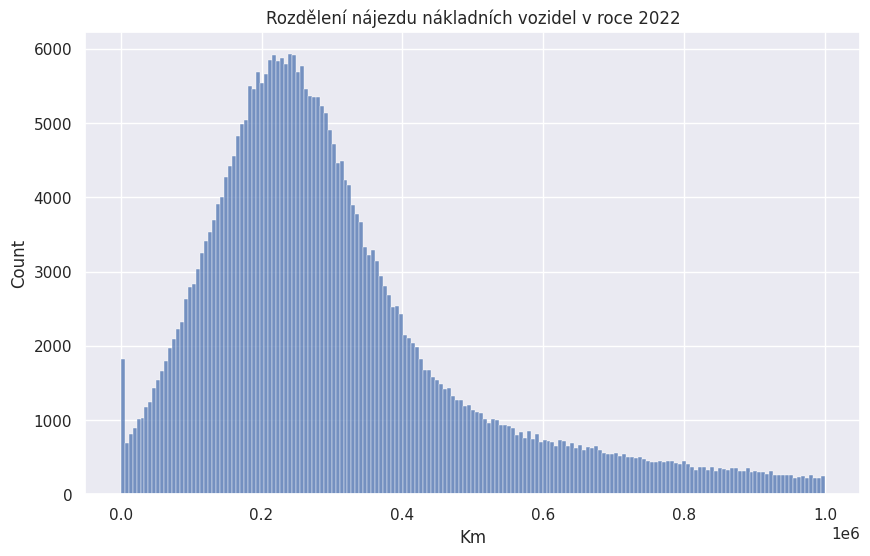

In [61]:
for type, df in [('osobních', dfs_p['2022']), ('nákladních', dfs_np['2022'])]:
    plt.title(f'Rozdělení nájezdu {type} vozidel v roce 2022')
    sns.histplot(df['Km'])
    plt.show()